<a href="https://colab.research.google.com/github/DanielaCaroline18/NLP/blob/main/NLP_Aula4_Pos_tagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m spacy download pt
!python -m spacy download en
!pip install spacy
!pip install beautifulsoup4

     |████████████████████████████████| 21.2MB 848kB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-cp36-none-any.whl size=21186282 sha256=b80ad50521bde3cc89071993c3207af8991ad38835f05b6c7f36bdf502f7a512
  Stored in directory: /tmp/pip-ephem-wheel-cache-35nhrcox/wheels/ea/94/74/ec9be8418e9231b471be5dc7e1b45dd670019a376a6b5bc1c0
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [ ]:
import nltk
import spacy
from spacy import displacy 
import tqdm
import operator
import requests
from bs4 import BeautifulSoup
import re
import pt_core_news_sm
import en_core_web_sm
from collections import Counter
import random
import operator
import matplotlib.pyplot as plt

# Pos tagging

## Abordagem Manual

Em empresas, quando queremos construir/usar um POS Tagging, estamos buscando uma ferramenta para trabalhar em algum cenário específico e direcionado ao negócio. Por exemplo, recuperar todos os verbos de um texto, para analisar de forma geral as ações que um cliente conecta com a marca no Twitter. Nesse sentido, podemos usar duas abordagens:

    1 - Construir um modelo próprio que resolva esse cenário
    2 - Usar modelos que já existem e, se necessário, treiná-los para melhor performance no nosso cenário

Para esse exercício, vamos simular esse cenário de recuperar verbos de um texto. Apesar da abordagem 2 parecer mais interessante, vamos tentar construir nosso próprio modelo e aprender um pouco sobre a complexidade do problema.

Inicialmente, vamos reduzir bem nosso escopo, focando em

    - REGEX com NamedGoups
    - Verbos simples, como estudar
    
Use o método abaixo para verificar quais grupos foram identificados pela expressão regular:

```python
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})
```

Mais informações de regex: https://docs.python.org/pt-br/3.8/howto/regex.html

In [ ]:
def print_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    for m in regex.finditer(phrase):
        print({k:v for(k,v) in m.groupdict().items() if v is not None})

In [ ]:
phrase1 = "eu estudo, você estuda, nós estudamos e vc sabe como é... estudos em todo lugar "

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w?\b)'

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}


<b> Atividade </b>

1) Modifique o padrão da regex para conseguir reconhecer todas as conjugações do verbo estudar na 'phrase1'

In [ ]:
estudar_pattern_try1 = r'(?P<VERB_ESTUDAR>\bestud\w*\b)'

In [ ]:
print_found_groups(estudar_pattern_try1, phrase1)

{'VERB_ESTUDAR': 'estudo'}
{'VERB_ESTUDAR': 'estuda'}
{'VERB_ESTUDAR': 'estudamos'}
{'VERB_ESTUDAR': 'estudos'}


<b> Atividade </b>

2) A solução da atividade 1 trouxe todos verbos? Todas as palavras eram verbos? 

A solução trouxe todos os verbos, entretando trouxe também um substantivo, portando, o regex não pode ser usado com o objetivo de diferenciar o tipo semâtico de cada palavra, mas pode ser utilizados em contextos em que a semântica não é relevante.

<b> Atividade </b>

3) Modifique o padrão da regex para identificar todos os verbos da frase abaixo. 

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Observe que 'acessar' e 'acesso', apesar de serem palavras semelhantes, despenham papéis diferentes. O 'acesso' é um caso claro de polissemia. Observe as duas frases abaixo que isto ficará mais claro:

    - Meu acesso funcionou -> Aqui é substantivo
    - Eu acesso a aula -> Aqui é verbo

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [ ]:
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }

In [ ]:
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."

In [ ]:
estudar_pattern_try1 = r'(?P<VERBS>uso|)'

In [ ]:
verbo_lista =  ["uso", "faz\w{0,4}", "é", "ver", "acess\w{1,2}", "realizar"]
padrao_verbos = r'(?P<VERBS>' + "|".join(verbo_lista) +')'

In [ ]:
verbos = get_found_groups(padrao_verbos, phrase2)
verbos

{'acessar': 'VERBS',
 'acesso': 'VERBS',
 'fazemos': 'VERBS',
 'realizar': 'VERBS',
 'uso': 'VERBS',
 'ver': 'VERBS',
 'é': 'VERBS'}

<b> Atividade </b>

4) Modifique o padrão da regex para identificar todos os substantivos da frase abaixo. 

```python
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."
```

Utilize o método abaixo para retornar os grupos de acordo com a expressão regular construída:
```python
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }
```

In [ ]:
phrase2 = "O principal uso que fazemos do canvas é ver e entregar exercícios, além de acessar os materiais postados pelos professores. É importante realizar o acesso todos os dias."

In [ ]:
def get_found_groups(pattern, phrase):
    regex = re.compile(pattern)
    return {v:k for m in regex.finditer(phrase) for(k,v) in m.groupdict().items() if v is not None }

In [ ]:
subs_list=["canvas", "professor\w{0,2}", "materia\w{0,2}", "exercício\w{0,1}", "dia\w{0,1}", "acesso"]
padrao_subs = r'(?P<SUBS>' + "|".join(subs_list) +')'

In [ ]:
subs = get_found_groups(padrao_subs, phrase2)
subs

{'acesso': 'SUBS',
 'canvas': 'SUBS',
 'dias': 'SUBS',
 'exercícios': 'SUBS',
 'materiais': 'SUBS',
 'professores': 'SUBS'}

<b> Atividade </b>

5) Essa abordagem de construção da regex para taggear as palavras é uma tarefa simples? Qual o valor/aplicação você consegue enxergar para ela?

> A terefa não é simples porque é necessário fazer um regex para cada uma das palavras da frase, o que torna a tarefa custosa, pricipalmente se o número de palavras é grande. Além disso, existe um  problema para de fato saber o tipo semântico da palavra.


> Entretanto,o tagueamento com regex pode ser usado para aumentar os dados de treinamento com palavras novas, afim de criar modelos mais robustos que posteriormente podem serem usados em abordagens automáticas.



<b> Atividade </b>

6) Nas atividades 3 e 4 você retornou todos os substantivos e verbos da phrase2. Agora marque-os na frase.  O retorno esperado da frase é: 

``O principal uso_VERB que fazemos_VERB do canvas é ver_VERB e entregar_VERB exercícios, além de acessar_VERB os materiais postados pelos professores. É importante realizar_VERB o acesso_SUBS|VERB todos os dias.``

Observe que a palavra acesso tem duas tags = SUBS e VERB.

In [ ]:
#varrer a frase tokenizada e verificar se ela está na lista de verbos ou subs

def pre_processamento(corpus):
    #tokenizacao"
    corpus_alt = re.findall(r"\w+(?:'\w+)?|[^\w\s]", corpus)
     
    return corpus_alt

In [ ]:
corpus_processado = pre_processamento(phrase2)  

In [ ]:
frase = []
for palavra in corpus_processado:
  if (palavra in verbos and palavra in subs):
          palavra = palavra + "_SUBS|VERB"
  elif ( palavra in verbos ):
      palavra = palavra + "_VERB"
  elif ( palavra in subs ):
      palavra = palavra + "_SUBS"
    
  frase.append(palavra)

frase = ' '.join(frase)

print(frase)


O principal uso_VERB que fazemos_VERB do canvas_SUBS é_VERB ver_VERB e entregar exercícios_SUBS , além de acessar_VERB os materiais_SUBS postados pelos professores_SUBS . É importante realizar_VERB o acesso_SUBS|VERB todos os dias_SUBS .


## Mac_Morpho com NLTK

In [ ]:
nltk.download('mac_morpho')
print("WORDS ", nltk.corpus.mac_morpho.tagged_words())
print("______________")
print("SENTS ",nltk.corpus.mac_morpho.tagged_sents())

[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.
WORDS  [('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ...]
______________
SENTS  [[('Jersei', 'N'), ('atinge', 'V'), ('média', 'N'), ('de', 'PREP'), ('Cr$', 'CUR'), ('1,4', 'NUM'), ('milhão', 'N'), ('em', 'PREP|+'), ('a', 'ART'), ('venda', 'N'), ('de', 'PREP|+'), ('a', 'ART'), ('Pinhal', 'NPROP'), ('em', 'PREP'), ('São', 'NPROP'), ('Paulo', 'NPROP')], [('Programe', 'V'), ('sua', 'PROADJ'), ('viagem', 'N'), ('a', 'PREP|+'), ('a', 'ART'), ('Exposição', 'NPROP'), ('Nacional', 'NPROP'), ('do', 'NPROP'), ('Zebu', 'NPROP'), (',', ','), ('que', 'PRO-KS-REL'), ('começa', 'V'), ('dia', 'N'), ('25', 'N|AP')], ...]


In [ ]:
words_tagged = nltk.corpus.mac_morpho.tagged_words()

In [ ]:
len(words_tagged)

1170095

<b> Atividade </b>

7) Gere a quantidade de itens de cada tag no mac_morpho

In [ ]:
tags ={}
for w, t in words_tagged:
  if t  not in tags.keys():
    tags[t] = 1
  else:
    tags[t] +=1

In [ ]:
tags

{'!': 919,
 '"': 21069,
 '$': 60,
 "'": 510,
 '(': 7713,
 '((': 10,
 ')': 7741,
 '))': 10,
 ',': 68494,
 '-': 3117,
 '.': 82,
 '...': 84,
 '/': 95,
 ':': 6736,
 ';': 1376,
 '=': 14,
 '?': 1510,
 'ADJ': 53372,
 'ADJ|+': 11,
 'ADJ|EST': 174,
 'ADV': 30653,
 'ADV-KS': 392,
 'ADV-KS-REL': 898,
 'ADV|+': 8,
 'ADV|EST': 9,
 'ADV|HOR': 9,
 'ADV|[': 18,
 'ADV|]': 13,
 'ART': 151891,
 'ART|+': 7,
 'ART|EST': 4,
 'CUR': 2706,
 'IN': 415,
 'IN|EST': 1,
 'KC': 28262,
 'KC|+': 2,
 'KC|EST': 2,
 'KC|[': 143,
 'KC|]': 133,
 'KS': 14320,
 'KS|[': 5,
 'KS|]': 4,
 'N': 236462,
 'NPRO': 3,
 'NPROP': 114318,
 'NPROP|+': 35,
 'NUM': 18110,
 'NUM|TEL': 2,
 'N|AP': 4350,
 'N|DAD': 255,
 'N|DAT': 285,
 'N|EST': 2807,
 'N|HOR': 913,
 'N|TEL': 866,
 'PCP': 23092,
 'PDEN': 6786,
 'PDEN|EST': 2,
 'PREP': 104364,
 'PREP|': 2,
 'PREP|+': 78274,
 'PREP|+]': 7,
 'PREP|EST': 3,
 'PREP|[': 20,
 'PREP|]': 9,
 'PRO-KS': 2150,
 'PRO-KS-REL': 11347,
 'PROADJ': 20919,
 'PROADJ|+': 2,
 'PROP': 7,
 'PROPESS': 14718,
 'PROPESS

In [ ]:
tags_sorted =  sorted(tags.items(), key=operator.itemgetter(1))
tags_sorted

[('VAUX|!', 1),
 ('IN|EST', 1),
 ('V|!', 1),
 ('NUM|TEL', 2),
 ('PREP|', 2),
 ('KC|EST', 2),
 ('PROADJ|+', 2),
 ('PROPESS|EST', 2),
 ('PDEN|EST', 2),
 ('PROPESS|+', 2),
 ('KC|+', 2),
 ('NPRO', 3),
 ('PREP|EST', 3),
 ('`', 3),
 ('ART|EST', 4),
 ('KS|]', 4),
 ('V|EST', 5),
 ('KS|[', 5),
 ('ART|+', 7),
 ('PREP|+]', 7),
 ('PROP', 7),
 ('ADV|+', 8),
 ('PREP|]', 9),
 ('ADV|EST', 9),
 ('ADV|HOR', 9),
 ('((', 10),
 ('))', 10),
 ('ADJ|+', 11),
 ('ADV|]', 13),
 ('=', 14),
 ('ADV|[', 18),
 ('PREP|[', 20),
 ('[', 23),
 ('NPROP|+', 35),
 ('$', 60),
 ('.', 82),
 ('...', 84),
 ('/', 95),
 ('VAUX|+', 99),
 ('KC|]', 133),
 ('KC|[', 143),
 ('ADJ|EST', 174),
 ('N|DAD', 255),
 ('N|DAT', 285),
 ('ADV-KS', 392),
 ('IN', 415),
 ("'", 510),
 ('N|TEL', 866),
 ('ADV-KS-REL', 898),
 ('N|HOR', 913),
 ('!', 919),
 (';', 1376),
 ('?', 1510),
 ('PRO-KS', 2150),
 ('V|+', 2373),
 ('CUR', 2706),
 ('N|EST', 2807),
 ('-', 3117),
 ('N|AP', 4350),
 (':', 6736),
 ('PDEN', 6786),
 ('(', 7713),
 (')', 7741),
 ('PROSUB', 8598)

8) Quais são as tags mais com maior frequência? E quais com menor? Esse resultado faz sentido?

>As tags com maio número são os substantivos (N) e os artigos (ART) e o de menor número são os verbos reflexivos (VAUX) e as interjeições (IN).

>O resultado faz sentido pois os substantivos e artigos são formas semânticas utilizadas o tempo todo para nomear pessoas e objetos e o artigo sempre acompanha o substantivo sendo este definido ou indefinido, já verbos reflexivo, interjeições e preposições são palavras pouco usadas no dia-a-dia e em textos em geral.

## POS Tagging com Spacy - Desambiguando frases

Uma das aplicações do pos tagging é auxiliar na desambiguação de palavras. Uma mesma palavra pode desempenhar funções semântias diferentes, dependendo do contexto.

<b> Atividade </b>

9) Considere as frases abaixo:

9.1) frases grupo1:
```python
frase0="Ele foi andar"
frase1="O andar estava triste"
```

9.2) frase grupo2:
```python
frase2="Essa cola cola papel"
```
9.3) frases grupo3:
```python
frase3="Hora de fazer imposto de renda"
frase4="Aquilo foi imposto pelo chefe"
```

9.4) frases grupo4:
```python
frase5="Hora de fazer imposto de renda"
frase6="Aquilo foi imposto pelo chefe"
```

9.5) frases grupo5:
```python
frase7="Todo dia eu caminho"
frase8="Esse é o caminho mais fácil"
```

Utilizando o modelo ``pt_core_news_sm`` da biblioteca spacy faça as seguinte análises. Para cada token:

- a) imprima a função sintática (pos-tagging) em texto
- b) relação de dependência sintática em texto
- c) gera uma imagem das relações acims utilizando o método abaixo:
- d) análise a palavra em comum, descreva a diferença sintática encontrada e responda se é gramaticamente correta

```python
#Para imprimir detalhes
displacy.render(doc, style='dep',jupyter=True)

```

Dica: https://spacy.io/api/annotation

In [ ]:
nlp = pt_core_news_sm.load()

<b> Atividade </b>

9.1 Frases Grupo 1

In [ ]:
txt0="Ele foi andar"
txt1="O andar estava triste"

In [ ]:
def analisa_texto(txt):
  doc = nlp(txt)
  for token in doc:
    print("Token =  ", token)
    print("\t a) tag  = ",  token.pos_)
    print("\t b) dep  = ",  token.dep_)
  displacy.render(doc, style='dep',jupyter=True)
  print("__________________________")

In [ ]:
analisa_texto(txt0)
analisa_texto(txt1)

Token =   Ele
	 a) tag  =  PRON
	 b) dep  =  nsubj:pass
Token =   foi
	 a) tag  =  AUX
	 b) dep  =  aux:pass
Token =   andar
	 a) tag  =  VERB
	 b) dep  =  ROOT


__________________________
Token =   O
	 a) tag  =  DET
	 b) dep  =  det
Token =   andar
	 a) tag  =  NOUN
	 b) dep  =  nsubj
Token =   estava
	 a) tag  =  VERB
	 b) dep  =  cop
Token =   triste
	 a) tag  =  ADJ
	 b) dep  =  ROOT


__________________________


<b> d) Disucussão Grupo 1: </b>


>A palavras andar apesar de ser comum nas 2 frases, possuem sentidos diferentes. Na primeira frase ela é um verbo, ou seja, no sentido de o sujeito (Ele), executar uma ação (andar). Entretanto, na segunda frase ela é um substativo, pois não descreve uma ação, e sim ,da nome a algo que vai ser adjetivado, isso é identificado pelo pronome detefinido (O) que antecede a palavra "andar" e também pelo adjetivo "triste" que descreve o sujeito.
 
>Nesse caso, a utilização do POS Tagging com Spacy foi capaz de diferencias o sentido semântico corretamente em cada uma das frases.

<b> Atividade </b>

9.2. Frase Grupo 2

In [ ]:
txt2="Essa cola cola papel"

In [ ]:
analisa_texto(txt2)

Token =   Essa
	 a) tag  =  DET
	 b) dep  =  det
Token =   cola
	 a) tag  =  NOUN
	 b) dep  =  ROOT
Token =   cola
	 a) tag  =  ADJ
	 b) dep  =  flat:name
Token =   papel
	 a) tag  =  PROPN
	 b) dep  =  flat:name


__________________________



>A palavras "cola" aparece duas vezes na frase, a primeira como substantivo e a segunda como verbo. Entretanto, utilizando o POS Tagging com Spacy não foi possível definir corretamente o sentido semântico da palavra "cola" como verbo, ele identificou apenas como adjetivo, o que faz sentido pois geralmente substantivos são acompanhados por adjetivos, mas não era o caso nessa situação. O motivo de ele não ter reconhecido o sentido semântico provavelmente se deve ao fato de nunca ter sido treinado com a palavra cola em um contexto similar.

<b> d) Disucussão Grupo 2: </b>

<b> Atividade </b>

9.3. Frases Grupo 3

In [ ]:
txt3="Segundo o que me disseram, ele estava triste"
txt4="No segundo dia de trabalho ela gastou menos"

In [ ]:
analisa_texto(txt3)
analisa_texto(txt4)

Token =   Segundo
	 a) tag  =  ADP
	 b) dep  =  case
Token =   o
	 a) tag  =  PRON
	 b) dep  =  obl
Token =   que
	 a) tag  =  PRON
	 b) dep  =  nsubj
Token =   me
	 a) tag  =  PRON
	 b) dep  =  iobj
Token =   disseram
	 a) tag  =  VERB
	 b) dep  =  acl:relcl
Token =   ,
	 a) tag  =  PUNCT
	 b) dep  =  punct
Token =   ele
	 a) tag  =  PRON
	 b) dep  =  nsubj
Token =   estava
	 a) tag  =  VERB
	 b) dep  =  cop
Token =   triste
	 a) tag  =  ADJ
	 b) dep  =  ROOT


__________________________
Token =   No
	 a) tag  =  ADP
	 b) dep  =  case
Token =   segundo
	 a) tag  =  ADJ
	 b) dep  =  amod
Token =   dia
	 a) tag  =  NOUN
	 b) dep  =  obl
Token =   de
	 a) tag  =  ADP
	 b) dep  =  case
Token =   trabalho
	 a) tag  =  NOUN
	 b) dep  =  nmod
Token =   ela
	 a) tag  =  PRON
	 b) dep  =  nsubj
Token =   gastou
	 a) tag  =  VERB
	 b) dep  =  ROOT
Token =   menos
	 a) tag  =  ADV
	 b) dep  =  advmod


__________________________


<b> d) Disucussão Grupo 3: </b>

>A palavra "segundo" na primeira frase foi identificado como adposição, que é um grupo de palavras que abrange as: preposições, posposições e circumposições, logo, a palavra "segundo" foi identificada corretamente, por se tratar de uma preposição. 

>Na segunda frase a palavra "segundo" foi identificada como adjetivo, entretanto, se trata de um numeral pois indica ou ocupa a posição correspondente ao número dois. O motivo dessa identificação incorreta pode ser pela palavra "dia" ser um substantivo e, por isso, o algoritmo definiu uma palavra que poderia descrevê-la.

<b> Atividade </b>

9.4. Frases Grupo 4

In [ ]:
txt5="Hora de fazer imposto de renda"
txt6="Aquilo foi imposto pelo chefe"

In [ ]:
analisa_texto(txt5)
analisa_texto(txt6)

Token =   Hora
	 a) tag  =  NOUN
	 b) dep  =  ROOT
Token =   de
	 a) tag  =  ADP
	 b) dep  =  mark
Token =   fazer
	 a) tag  =  VERB
	 b) dep  =  acl
Token =   imposto
	 a) tag  =  NOUN
	 b) dep  =  obj
Token =   de
	 a) tag  =  ADP
	 b) dep  =  case
Token =   renda
	 a) tag  =  NOUN
	 b) dep  =  nmod


__________________________
Token =   Aquilo
	 a) tag  =  PRON
	 b) dep  =  nsubj:pass
Token =   foi
	 a) tag  =  AUX
	 b) dep  =  aux:pass
Token =   imposto
	 a) tag  =  VERB
	 b) dep  =  ROOT
Token =   pelo
	 a) tag  =  ADP
	 b) dep  =  case
Token =   chefe
	 a) tag  =  NOUN
	 b) dep  =  obl


__________________________


<b> d) Disucussão Grupo 4: </b>

>A palavra "imposto" na primeira frase foi identicada como um (NOUN) substantivo, o que está correto, pois nomeia a taxa que será paga pelo sujeito da frase.

>Na segunda frase a palavra "imposto" foi identificada como verbo, o que no contexto está correto, pois tem o sentido de "colocar como obrigação". Logo, nas duas frases as palavras foram identificadas corretamente de acordo com o contexto.

<b> Atividade </b>

9.5. Frases Grupo 5

In [ ]:
txt7="Todo dia eu caminho"
txt8="Esse é o caminho mais fácil"

In [ ]:
analisa_texto(txt7)
analisa_texto(txt8)

Token =   Todo
	 a) tag  =  DET
	 b) dep  =  det
Token =   dia
	 a) tag  =  NOUN
	 b) dep  =  obl
Token =   eu
	 a) tag  =  PRON
	 b) dep  =  nsubj
Token =   caminho
	 a) tag  =  VERB
	 b) dep  =  ROOT


__________________________
Token =   Esse
	 a) tag  =  PRON
	 b) dep  =  nsubj
Token =   é
	 a) tag  =  VERB
	 b) dep  =  cop
Token =   o
	 a) tag  =  DET
	 b) dep  =  det
Token =   caminho
	 a) tag  =  NOUN
	 b) dep  =  ROOT
Token =   mais
	 a) tag  =  ADV
	 b) dep  =  advmod
Token =   fácil
	 a) tag  =  ADJ
	 b) dep  =  amod


__________________________


<b> d) Disucussão Grupo 5: </b>

>A palavra "caminho" na primeira frase foi identificada como verbo e na segunda como substantivo. O que faz sentido de acordo com o contexto da frase e se analisar é muito parecido com a primeira análise feita sobre a palavra "andar".

<b> Esse modelo do spacy para português, em 79,94 de acurácia no pos-tagging</b>

<b> Atividade </b>

10) Sabendo que o modelo que estamos utulizando possui acurácia de 79,94 no pos-tagging, encontre um exemplo que ele falhe.

In [ ]:
frase1 = "Espere 5 minutos"

In [ ]:
analisa_texto(frase1)

Token =   Espere
	 a) tag  =  VERB
	 b) dep  =  ROOT
Token =   5
	 a) tag  =  NUM
	 b) dep  =  nummod
Token =   minutos
	 a) tag  =  SYM
	 b) dep  =  obj


__________________________


>A palavra "minutos" foi identificada como símbolo mas se trata de um substativo.

In [ ]:
frase2 = "Ele ressucitou no terceiro dia"

In [ ]:
analisa_texto(frase2)

Token =   Ele
	 a) tag  =  PRON
	 b) dep  =  nsubj
Token =   ressucitou
	 a) tag  =  VERB
	 b) dep  =  ROOT
Token =   no
	 a) tag  =  ADP
	 b) dep  =  case
Token =   terceiro
	 a) tag  =  ADJ
	 b) dep  =  amod
Token =   dia
	 a) tag  =  NOUN
	 b) dep  =  obl


__________________________


>A palavra "terceiro" foi identificado como adjetivo, entretanto, é um numeral. Um numeral pode ser um adjetivo em frases como: "Essa carne é de segunda", ou seja, ele descreve algo, nesse caso a qualidade da carne. Mas na frase do exemplo acima não é o caso.

# Named Entity Recognition

## Recomendação de sites

<b> Atividade </b>

11) Capture o texto de cada notícia abaixo:

- 0 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml
- 1 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml
- 2 -> https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml
- 3 -> https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml
- 4 -> https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml
- 5 -> https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml
- 6 -> https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml
- 7 -> https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml
- 8 -> https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml
- 9 -> https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml

Para isto utilize o código abaixo:
```python
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text
```

In [ ]:
def match_class(target):                                                        
    def do_match(tag):                                                          
        classes = tag.get('class', [])                                          
        return all(c in classes for c in target)                                
    return do_match 

In [ ]:
def get_text_url(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, 'html5lib')
    #remove marcações de scripts e style
    texto = soup.find_all(match_class(["content-text__container"]))
    all_text = ""
    for t in texto:
        all_text += t.get_text()
    return all_text

In [ ]:
#dicionário
noticias ={}
noticias[0] = "https://g1.globo.com/sp/sao-paulo/noticia/2020/03/03/cai-para-130-numero-de-casos-suspeitos-de-coronavirus-no-estado-de-sao-paulo.ghtml"
noticias[1] = "https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml"
noticias[2] = "https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/04/ultimas-noticias-de-coronavirus-de-4-de-marco.ghtml"
noticias[3] = "https://g1.globo.com/economia/noticia/2020/03/04/projetos-reduzem-em-r-96-bilhoes-emendas-parlamentares-no-orcamento-2020-diz-governo.ghtml"
noticias[4] = "https://g1.globo.com/politica/noticia/2020/03/04/documento-liga-assessor-de-eduardo-bolsonaro-a-conta-em-rede-social-para-ataques-pessoais.ghtml"
noticias[5] = "https://g1.globo.com/rj/rio-de-janeiro/noticia/2020/03/04/flavio-bolsonaro-entra-com-recurso-para-tentar-paralisar-investigacao-sobre-suspeita-de-rachadinha.ghtml"
noticias[6] = "https://g1.globo.com/economia/noticia/2020/03/04/pib-do-brasil-cresce-11percent-em-2019.ghtml"
noticias[7] = "https://g1.globo.com/economia/noticia/2020/03/04/tudo-dentro-do-previsto-diz-paulo-guedes-sobre-resultado-do-pib.ghtml"
noticias[8] = "https://g1.globo.com/sp/santos-regiao/noticia/2020/03/04/sobe-numero-de-mortos-apos-temporal-na-baixada-santista.ghtml"
noticias[9] = " https://g1.globo.com/sp/sao-paulo/noticia/2020/03/04/ministerio-da-saude-confirma-terceiro-paciente-com-coronavirus-em-sp-um-quarto-caso-aguarda-contraprova.ghtml"

In [ ]:
get_text_url(noticias[0] )

' A Secretaria Estadual de Saúde de São Paulo divulgou nesta terça-feira (3) que caiu o número de pacientes com suspeita de coronavírus no estado. Enquanto na segunda-feira (2) eram 163 casos suspeitos, nesta terça são 130.  Foram descartados, ao todo, 104 casos no estado, destes, 56 foram nas últimas 24 horas. Entretanto, segundo informou a pasta, entre segunda (2) e terça (3), 23 novos surgiram.  Permanecem confirmados apenas 2 casos da doença no país, ambos no estado de São Paulo. Os pacientes estão em quarentena domiciliar. Ambos estiveram em viagem na Itália.  "Os dois confirmados estão evoluindo bem clinicamente, mas ainda têm alguns sintomas que fazem com que eles continuem em isolamento domiciliar", salientou Paulo Menezes, coordenador do comitê de operações emergenciais (COE) da Secretaria Estadual de Saúde.  O número de pessoas que tiveram contato com o segundo caso confirmado não foi divulgado pela secretaria. No primeiro caso confirmado, eram 34 pessoas, entre passageiros d

In [ ]:
texto_noticias =  {i:get_text_url(noticias[i]) for i in noticias.keys()}

<b> Atividade </b>

12) Capture as entidades de cada uma das notícias utilizando o modelo ``pt_core_news_sm`` do spacy.

<i> Dica: ents retorna as entidades de um texto </i>

In [ ]:
nlp = pt_core_news_sm.load()

In [ ]:
nlp_texto_noticias = {i:nlp(texto_noticias[i]) for i in noticias.keys()}

In [ ]:
entidades = {i:set(map(str, nlp_texto_noticias[i].ents)) for i in nlp_texto_noticias.keys()}

In [ ]:
entidades

{0: {'A Secretaria Estadual de Saúde de São Paulo',
  'Adolfo Lutz',
  'COE',
  'CVE',
  'Campanha Nacional de Vacinação',
  'Centro de Contingenciamento de Emergências',
  'Centro de Vigilância Epidemiológica',
  'David Uip',
  'Helena Sato',
  'Instituto Butantan',
  'Itália',
  'José Henrique Germann',
  'Menezes',
  'Milão',
  'Ministério da Saúde',
  'OMS',
  'Organização Mundial de Saúde',
  'Paulo Menezes',
  'R$',
  'Saúde',
  'Secretaria Estadual de Saúde',
  'Secretário de Estado da Saúde',
  'São Paulo',
  'Uip',
  'estado de São Paulo'},
 1: {'Adolfo Lutz',
  'Alemanha',
  'Brasil',
  'COE',
  'Campanha Nacional de Vacinação',
  'Centro de Contingência',
  'Centro de Contingência de São Paulo',
  'Colômbia',
  'David Uip',
  'Einstein',
  'Espanha',
  'Europa',
  'G1',
  'Hospital Albert Einstein',
  'Hospital Beneficência Portuguesa',
  'Instituto Adolfo Lutz',
  'Itália',
  'João Doria',
  'Menezes',
  'Milão',
  'Ministério da Saúde',
  'OMS',
  'Organização Mundial de S

<b> Atividade </b>

13) Quais são as 5 entidades que mais apareceram nas notíciais? Critique esse resultado, ele faz sentido?

In [ ]:
todas_entidades = []
for k in entidades.keys():
  todas_entidades.extend(entidades[k])

In [ ]:
Counter(todas_entidades).most_common(n=5)

[('R$', 7), ('Brasil', 5), ('Itália', 4), ('São Paulo', 4), ('G1', 4)]

O resultado faz sentido pois das notícias analisadas algumas delas falam do PIB o que justifica o aparecimento de "R$", além disso, todas elas estão relacionadas ao Brasil, justificando o aparecimento da segunda palavra.
A palavra "Itália" e "São Paulo" aparecem, pois em algumas das notícias é relatato que as primeiras pessoas diagnoticadas com coroanvirus em São Paulo estiveram na Itália, país que estava com uma forte onda no virus na época das notícias. A palavra "G1" aparece, pois a maioria dos textos coletados foram desse site. Portanto, o resultado é coerente.

<b> Atividade </b>

14) Para a notítica 0, imprima quais foram os tipos das entidades encontradas e plote um gráfico com esses dados.
Faça uma análise desse resultado

<i> Dica: label_ retorna o nome da entidade </i>

In [ ]:
labels = [x.label_ for x in nlp_texto_noticias[0].ents]

In [ ]:
labels

['MISC',
 'LOC',
 'LOC',
 'PER',
 'ORG',
 'ORG',
 'PER',
 'ORG',
 'PER',
 'LOC',
 'PER',
 'PER',
 'PER',
 'ORG',
 'MISC',
 'PER',
 'PER',
 'PER',
 'MISC',
 'MISC',
 'LOC',
 'LOC',
 'LOC',
 'LOC',
 'PER',
 'LOC',
 'LOC',
 'ORG',
 'ORG',
 'PER',
 'PER',
 'LOC',
 'ORG',
 'PER',
 'ORG']

In [ ]:
Counter(labels)

Counter({'LOC': 10, 'MISC': 4, 'ORG': 8, 'PER': 13})

In [ ]:
labels = dict(Counter(labels))

<BarContainer object of 4 artists>

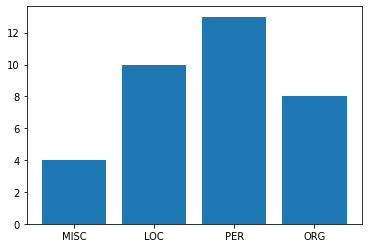

In [ ]:
plt.bar(labels.keys(), labels.values())

<b> Atividade </b>

15) Plote um gráfico com esses dados com todos os tipos das entidades de todas as notícias. Compare este resultado com o resultado da notícia 0.

Notícia [0]=
Counter({'PER': 13, 'LOC': 10, 'ORG': 8, 'MISC': 4})
Notícia [1]=
Counter({'LOC': 35, 'PER': 8, 'ORG': 7, 'MISC': 4})
Notícia [2]=
Counter({'LOC': 9})
Notícia [3]=
Counter({'PER': 14, 'LOC': 10, 'MISC': 6, 'ORG': 2})
Notícia [4]=
Counter({'PER': 19, 'LOC': 9, 'ORG': 8, 'MISC': 7})
Notícia [5]=
Counter({'LOC': 6, 'PER': 3, 'ORG': 1})
Notícia [6]=
Counter({'LOC': 12, 'PER': 10, 'MISC': 7, 'ORG': 1})
Notícia [7]=
Counter({'LOC': 13, 'PER': 8, 'MISC': 3, 'ORG': 2})
Notícia [8]=
Counter({'LOC': 48, 'ORG': 6, 'MISC': 3, 'PER': 2})
Notícia [9]=
Counter({'LOC': 35, 'PER': 8, 'ORG': 7, 'MISC': 4})


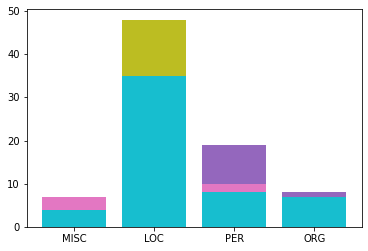

In [ ]:
for i in nlp_texto_noticias.keys():
  labels = [x.label_ for x in nlp_texto_noticias[i].ents]
  print("Notícia [" + str(i)+"]=")
  print (Counter(labels))
  labels = dict(Counter(labels))
  plt.bar(labels.keys(), labels.values())

> Ao plotar o gráfico de entidades para todas as notícias fica evidente que a entidade LOC (localidade) foi a mais utilizada em lugar de PER (Pessoas). Isso é coerente, porque se vermos as entidades listadas na atividade 12 é possivel observar que realmente número de localidades é maior, e a principal contribuição é feita pela notícia 8 que lista a localidade das chuvas e deslizamos ocorridos, e as outras notícias, como a 3, acabam contribuindo por listar os locais onde já tiver foram registrados casos de Covid e qual a atitude tomada por cada país.

<b> Atividade </b>

16) Imprima a notícia 0, colorindo as entidades encontradas, para isto utilize o método abaixo:

```python
displacy.render(doc, jupyter=True, style='ent')
```

<i> Dica: entidades que existem no spacy https://spacy.io/api/annotation#section-named-entities 

Caso tenha dúvida sobre alguma marcalçao use:</i>

```python
spacy.explain("MISC")
```

In [ ]:
displacy.render(nlp_texto_noticias[0], jupyter=True, style='ent')

<b> Atividade </b>

17) Seja o documento 0 sua referência. Calcule a similaridade das entidades do documento 0 com todos outros 9. Para calcular a similaridade utilize o método jacard (implementado na aula 3). 

In [ ]:
def jacard_similarity(list1, list2):
  s1 = set(list1)
  s2 = set(list2)
  return len(s1.intersection(s2))/len(s1.union(s2))

In [ ]:
for i in entidades.keys():
  print ("Doc ["+str(i)+"]")
  print (jacard_similarity(entidades[0], entidades[i]))

Doc [0]
1.0
Doc [1]
0.38636363636363635
Doc [2]
0.034482758620689655
Doc [3]
0.021739130434782608
Doc [4]
0.0
Doc [5]
0.03225806451612903
Doc [6]
0.022727272727272728
Doc [7]
0.023809523809523808
Doc [8]
0.017241379310344827
Doc [9]
0.38636363636363635


<b> Atividade </b>

18) Com os cálculos da questão anterior, responda: quais foram os três documentos com maior similaridade? Eles posssuem conteúdos semelhantes? E qual o documento com menor similaridade? Este documento faz sentido?

>Os 3 documento com maior similaridade em relação ao 0 são os documento 1, 2 e 9, o que faz total sentido pois todos tem como assunto principal o corononavirus, sendo dois deles relativos ao brasil (1 e 9), assim como o documento 0, e o outro (doc 2) um resumo sobre as últimas notícias relativas ao corona em todo o mundo.

>O documento com menor similaridade em relação ao doc 0 foi o doc 8 que fala sobre "o número de mortos após temporal na Baixada Santista", acho que faz sentido pois o doc 0 apesar de falar sobre o Covid faz muita referência ao governo de forma geral, organizações como secretarias e ao próprio ministério da saúde, o que ocorre de certa forma nas outras notícias, mas na noticía da Baixada Santista o foco é apenas nas localidades onde a população foi atingida pelo temporal.

## Retreino NER

Aqui nós iremos ilustrar como treinar um modelo NER no spacy

In [ ]:
texto = "João nasceu em Paris em 01/01/2000"

In [ ]:
texto_nlp = nlp(texto)

In [ ]:
displacy.render(texto_nlp, style='ent',jupyter=True)

Observe que o modelo identifica <b> João </b> como pessoa e <b> Paris </b> como localidade.

Apesar do modelo ter identificado essas duas entidades ele naõ identificou a <b> data </b>.

Assim, aqui iremos mostrar como retreinar o modelo para capturar também a data.


In [ ]:
#dados de treino. Note que para cada frase, a posição de uma determinada entidade.
train_data = [
("Em 04/12/1992 nasceu Joana", {'entities':[(3, 13, "DATE"), (21,26, "PER")]}),
("Data de início: 10/01/2018", {'entities':[(16, 26, "DATE")]}),
("Maria se mudou para Paris", {'entities':[(20,26, "LOC")]}),
("Paris cidade das luzes", {'entities':[(0,5, "LOC")]}),    
("Maria nasceu em Contagem no dia 07/05/2018", {'entities':[(0,5,"PER"),(16,24,"LOC"),(32,42, "DATE")]})
]

### Retreino

- explosion/spaCy/master/examples/training/train_ner.py -> O spcay disponibiliza esse código para treinamentos.
- Mais informações? https://spacy.io/usage/training

In [ ]:
def train_spacy(data, iterations):
    TRAIN_DATA = data
    nlp = spacy.blank('pt')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)
       

    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(iterations):
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.2,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)           
    return nlp

In [ ]:
modelo_novo = train_spacy(train_data, 30)

KeyboardInterrupt: ignored

In [ ]:
modelo_novo.to_disk("modelo_novo_NER")

<b> Atividade </b>

19) O ``modelo_novo`` já foi criado. Aplique o texto em que demonstramos que a data não foi identificada e depois imprima utilizando o ``displacy``.
O problema foi resolvido?

In [ ]:
texto_nlp_novo = modelo_novo(texto)

In [ ]:
displacy.render(texto_nlp_novo, style='ent',jupyter=True)

> O problema foi resolvido e a data foi identificada, o interessante foi notar é que não é necessário um grande conjunto de dados para que a rede seja retreinada